## 第6章: 機械学習
本章では，Fabio Gasparetti氏が公開しているNews Aggregator Data Setを用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む．

### 50. データの入手・整形
News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．

1. ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
2. 情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
3. 抽出された事例をランダムに並び替える．
4. 抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．

学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [1]:
import numpy as np
import pandas as pd

In [2]:
df_raw = pd.read_csv("newsCorpora.csv", sep="\t", names=['id','title','url','publisher','category','story','hostname','timestamp'])

# 2.
pub_list = ["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"]
df = df_raw[df_raw["publisher"].isin(pub_list)]
df.head()

,id,title,url,publisher,category,story,hostname,timestamp
12,13,Europe reaches crunch point on banking union,http://in.reuters.com/article/2014/03/10/eu-ba...,Reuters,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,in.reuters.com,1394470501755
13,14,ECB FOCUS-Stronger euro drowns out ECB's messa...,http://in.reuters.com/article/2014/03/10/ecb-p...,Reuters,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,in.reuters.com,1394470501948
19,20,"Euro Anxieties Wane as Bunds Top Treasuries, S...",http://www.businessweek.com/news/2014-03-10/ge...,Businessweek,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,www.businessweek.com,1394470503148
20,21,Noyer Says Strong Euro Creates Unwarranted Eco...,http://www.businessweek.com/news/2014-03-10/no...,Businessweek,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,www.businessweek.com,1394470503366
29,30,REFILE-Bad loan triggers key feature in ECB ba...,http://in.reuters.com/article/2014/03/10/euroz...,Reuters,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,in.reuters.com,1394470505070


In [3]:
# 3., 4.
train, valid, test = np.split(df.sample(frac=1, random_state=42), [int(0.8*len(df)), int(0.9*len(df))])
train[["category", "title"]].to_csv("train.txt", sep="\t", index=False)
valid[["category", "title"]].to_csv("valid.txt", sep="\t", index=False)
test[["category", "title"]].to_csv("test.txt", sep="\t", index=False)

In [4]:
# 各カテゴリの事例数を確認
print(train["category"].value_counts())
print(valid["category"].value_counts())
print(test["category"].value_counts())

b    4530
e    4178
t    1225
m     739
Name: category, dtype: int64
e    560
b    539
t    144
m     91
Name: category, dtype: int64
b    558
e    541
t    155
m     80
Name: category, dtype: int64


### 51. 特徴量抽出
学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

In [5]:
# tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

# vectorize
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train["title"])
X_valid = vectorizer.transform(valid["title"])
X_test = vectorizer.transform(test["title"])

In [6]:
# save files
columns = vectorizer.get_feature_names_out()
train_feat = pd.DataFrame(X_train.toarray(), columns=columns)
valid_feat = pd.DataFrame(X_valid.toarray(), columns=columns)
test_feat = pd.DataFrame(X_test.toarray(), columns=columns)

train_feat.to_csv("train.feature.txt", sep="\t", index=False)
valid_feat.to_csv("valid.feature.txt", sep="\t", index=False)
test_feat.to_csv("test.feature.txt", sep="\t", index=False)

### 52. 学習
51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [7]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=42, max_iter=500)
model.fit(train_feat, train["category"])

LogisticRegression(max_iter=500, random_state=42)

### 53. 予測
52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [8]:
Y_train = model.predict(train_feat)
proba_train = model.predict_proba(train_feat)
Y_valid = model.predict(valid_feat)
proba_valid = model.predict_proba(valid_feat)
Y_test = model.predict(test_feat)
proba_test = model.predict_proba(test_feat)

In [9]:
print(Y_valid)
print(proba_valid)

['e' 'e' 'b' ... 'b' 't' 'b']
[[0.26367688 0.54214256 0.07528668 0.11889387]
 [0.00987383 0.98351177 0.00341373 0.00320067]
 [0.95583354 0.02118243 0.00817798 0.01480605]
 ...
 [0.85839164 0.06735064 0.03146091 0.04279681]
 [0.18981717 0.04190752 0.02567741 0.7425979 ]
 [0.97680933 0.0094332  0.00552706 0.00823041]]


### 54. 正解率の計測
52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．

In [10]:
from sklearn.metrics import accuracy_score

acc_train = accuracy_score(Y_train, train["category"])
acc_valid = accuracy_score(Y_valid, valid["category"]) # or: model.score(valid_feat, valid["category"])

acc_train, acc_valid

(0.9438718140929535, 0.8920539730134932)

### 55. 混同行列の作成
52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

[[0.94504792 0.00468584 0.01810437 0.03216187]
 [0.01259559 0.93387314 0.02699055 0.02654071]
 [0.01119403 0.         0.9869403  0.00186567]
 [0.03115578 0.0040201  0.00502513 0.95979899]] [[0.88737201 0.02389078 0.01877133 0.06996587]
 [0.01809211 0.89473684 0.03618421 0.05098684]
 [0.         0.         0.96551724 0.03448276]
 [0.09756098 0.02439024 0.02439024 0.85365854]]


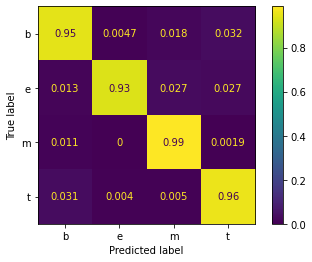

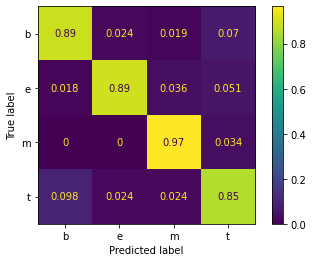

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_train = confusion_matrix(Y_train, train["category"], normalize="true")
cm_valid = confusion_matrix(Y_valid, valid["category"], normalize="true")
print(cm_train, cm_valid)

disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=model.classes_)
disp_train.plot()

disp_valid = ConfusionMatrixDisplay(confusion_matrix=cm_valid, display_labels=model.classes_)
disp_valid.plot()

### 56. 適合率，再現率，F1スコアの計測
52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

In [12]:
from sklearn.metrics import precision_recall_fscore_support as prfs

prf_by_class = prfs(Y_valid, valid["category"], average=None, labels=model.classes_)
prf_macro = prfs(Y_valid, valid["category"], average="macro", labels=model.classes_)
prf_micro = prfs(Y_valid, valid["category"], average="micro", labels=model.classes_)

# 配列で適合率、再現率、f1の順で値が格納される
print("\t\tPrecision\t\tRecall\t\tF-1")
print(f"macro-avg:{prf_macro}")
print(f"micro-avg:{prf_micro}")

# それぞれ適合率、再現率、f1（、出現頻度）の配列
print(f"\nclass:{model.classes_}")
prf_by_class

		Precision		Recall		F-1
macro-avg:(0.7594184585256014, 0.9003211584304541, 0.8067745431642946, None)
micro-avg:(0.8920539730134932, 0.8920539730134932, 0.8920539730134932, None)

class:['b' 'e' 'm' 't']


(array([0.96474954, 0.97142857, 0.61538462, 0.48611111]),
 array([0.88737201, 0.89473684, 0.96551724, 0.85365854]),
 array([0.92444444, 0.93150685, 0.75167785, 0.61946903]),
 array([586, 608,  58,  82]))

### 57. 特徴量の重みの確認
52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

In [21]:
for i in range(len(model.classes_)):
    print(f"class: {model.classes_[i]}")
    print(f"- 高10: {model.feature_names_in_[np.argsort(model.coef_[i])[-1:-10:-1]]}")
    print(f"- 低10: {model.feature_names_in_[np.argsort(model.coef_[i])[:10]]}")

class: b
- 高10: ['china' 'fed' 'bank' 'stocks' 'ecb' 'euro' 'update' 'ukraine' 'oil']
- 低10: ['and' 'ebola' 'the' 'her' 'she' 'apple' 'google' 'facebook' 'kardashian'
 'star']
class: e
- 高10: ['kardashian' 'chris' 'her' 'she' 'star' 'kim' 'miley' 'cyrus' 'movie']
- 低10: ['update' 'us' 'google' 'ceo' 'china' 'says' 'facebook' 'gm' 'apple'
 'study']
class: m
- 高10: ['ebola' 'study' 'cancer' 'fda' 'drug' 'mers' 'health' 'cigarettes'
 'cases']
- 低10: ['gm' 'google' 'facebook' 'apple' 'climate' 'ceo' 'twitter' 'deal' 'bank'
 'sales']
class: t
- 高10: ['google' 'apple' 'facebook' 'microsoft' 'climate' 'gm' 'tesla' 'comcast'
 'mobile']
- 低10: ['stocks' 'shares' 'fed' 'drug' 'her' 'american' 'cancer' 'kardashian'
 'ecb' 'ebola']


### 58. 正則化パラメータの変更
ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

In [29]:
import matplotlib.pyplot as plt

# default c = 1.0
c_list = [0.01, 0.05, 0.10, 0.50, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0]
train_acc = []
test_acc = []
valid_acc = []
for c in c_list:
    # train model
    tmp_model = LogisticRegression(random_state=42, max_iter=500, C=c)
    tmp_model.fit(train_feat, train["category"])
    
    # determine accuracy(正解率)
    train_acc.append( tmp_model.score(train_feat, train["category"]) )
    test_acc.append( tmp_model.score(test_feat, test["category"]) )
    valid_acc.append( tmp_model.score(valid_feat, valid["category"]) )

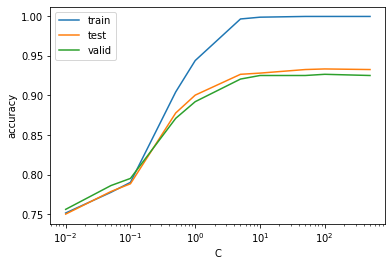

In [32]:
plt.plot(c_list, train_acc, label="train")
plt.plot(c_list, test_acc, label="test")
plt.plot(c_list, valid_acc, label="valid")
plt.xlabel("C")
plt.ylabel("accuracy")
plt.xscale('log')
plt.legend()
plt.show()

### 59. ハイパーパラメータの探索
学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

In [42]:
# max_iter = 500 + find argmax C (regularization)
# lbfgs, l2
print(f"acc = {max(valid_acc)}, C = {c_list[valid_acc.index(max(valid_acc))]}")

acc = 0.9265367316341829, C = 100.0


In [43]:
# default c = 1.0
c_list = [0.10, 1.0, 10.0, 100.0, 500.0]

# assume: max_iter = 500 + find argmax C (regularization)
# saga, l2
train_acc_saga_l2 = []
test_acc_saga_l2 = []
valid_acc_saga_l2 = []
for c in c_list:
    # train model
    tmp_model = LogisticRegression(random_state=42, max_iter=500, solver="saga", C=c)
    tmp_model.fit(train_feat, train["category"])
    
    # determine accuracy(正解率)
    train_acc_saga_l2.append( tmp_model.score(train_feat, train["category"]) )
    test_acc_saga_l2.append( tmp_model.score(test_feat, test["category"]) )
    valid_acc_saga_l2.append( tmp_model.score(valid_feat, valid["category"]) )

/Users/panatchakorn-a/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [47]:
print(f"acc = {max(valid_acc_saga_l2)}, C = {c_list[valid_acc_saga_l2.index(max(valid_acc_saga_l2))]}")

acc = 0.9265367316341829, C = 100.0


In [52]:
# saga, l1
c_list_3 = [1, 10, 100, 500]
train_acc_saga_l1 = []
test_acc_saga_l1 = []
valid_acc_saga_l1 = []
for c in c_list:
    # train model
    tmp_model = LogisticRegression(random_state=42, max_iter=500, solver="saga", penalty="l1", C=c)
    tmp_model.fit(train_feat, train["category"])
    
    # determine accuracy(正解率)
    train_acc_saga_l1.append( tmp_model.score(train_feat, train["category"]) )
    test_acc_saga_l1.append( tmp_model.score(test_feat, test["category"]) )
    valid_acc_saga_l1.append( tmp_model.score(valid_feat, valid["category"]) )

/Users/panatchakorn-a/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/panatchakorn-a/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/panatchakorn-a/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/panatchakorn-a/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [54]:
print(f"acc = {max(valid_acc_saga_l1)}, C = {c_list[valid_acc_saga_l2.index(max(valid_acc_saga_l2))]}")

acc = 0.9250374812593704, C = 100.0


note: L1 の収束がより遅かった。